In [2]:
import pydicom
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [63]:
from os import walk
#PathDicom = './Pointrobotics/ImageDB/Image_20180509/Image_20180509/Case2/CT/S6220/S2010_TH3_Gap3/'
PathDicom = './dicom/S2010_TH3_Gap3/'
#PathDicom = './dicom/c1/'
lstFilesDCM = []
# get all file name in a directory
for (dirpath, dirnames, filenames) in walk(PathDicom):
    lstFilesDCM.extend(filenames)
    break
for i in range(len(lstFilesDCM)):
    lstFilesDCM[i] = PathDicom + lstFilesDCM[i]

In [64]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0], force=True)
print(RefDs)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20171205'
(0008, 0013) Instance Creation Time              TM: '153946.579'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.46.670589.33.1.63648085186573563700001.5182797186111580302
(0008, 0020) Study Date                          DA: '20171205'
(0008, 0021) Series Date                         DA: '20171205'
(0008, 0022) Acquisition Date                    DA: '20171205'
(0008, 0023) Content Date                        DA: '20171205'
(0008, 002a) Acquisition DateTime                DT: '20171205023925.050'
(0008, 0030) Study Time                          TM: '153723.961'
(0008, 0031) Series Time                         TM: '153939.905'
(0008, 0032) Acquisition Time                    TM: '153925'
(0008, 0

In [65]:
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print (ConstPixelDims)
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print (ConstPixelSpacing)

(512, 512, 134)
(0.46484375, 0.46484375, 3.0)


In [100]:
import shutil #use to delete dir
directory = './tiff/'
shutil.rmtree(directory, ignore_errors=True)# delete dir
if not os.path.exists(directory):
    os.makedirs(directory)
    
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

In [89]:
def IP(img):
    # filter grayscale 800~2000
    #img = np.clip(img,800,2000)
    # Normalised [0,255]
    #img = (img - 800) / 2500 * 255
    # uint16 uint8
    #img = img.astype(np.uint8)
    # Histograms Equalization
    img = cv2.equalizeHist(img)
    # GaussianBlur
    img = cv2.GaussianBlur(img,(7,7),0,0)
    # Threshold
    Threshold = 230
    img = (img > Threshold) * 255
    img = img.astype(np.uint8)
    # MedianBlur
    img = cv2.medianBlur(img, 7)
    return img

(134, 512, 512)


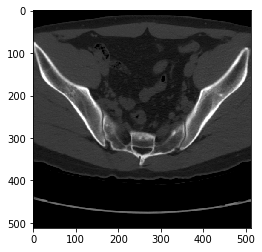

In [128]:
size = ConstPixelDims[0]
data_shape = (len(lstFilesDCM), size, size)
X = np.zeros(data_shape)
Y = np.zeros(data_shape)
Y_mask = np.zeros(data_shape)

i = 0
# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # file name
    filename = filenameDCM.split('/')[-1]
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    img = ds.pixel_array
    # filter grayscale 800~2000
    img = np.clip(img,800,2000)
    # Normalised [0,255]
    img = (img - 800) / 2500 * 255
    img = img.astype(np.uint8)
    
    # generate y
    img_y = IP(img)
    
    Y[i,:,:] = img_y

    # convert y to mask
    img_y = img_y / 255
    img_y = np.where(img_y>0.5,0,1)

    X[i,:,:] = img
    Y_mask[i,:,:] = img_y
    i += 1
print(X.shape)
plt.imshow(X[10], cmap='gray')

In [129]:
# resize the 3d image
from scipy.ndimage import zoom
rate = 1 / ConstPixelSpacing[0]
X = zoom(X, (rate, 1, 1))
Y = zoom(Y, (rate, 1, 1))
Y_mask = zoom(Y_mask, (rate, 1, 1))
print(X.shape)
print(Y.shape)
print(Y_mask.shape)

(288, 512, 512)
(288, 512, 512)
(288, 512, 512)


In [131]:
for i in range(X.shape[0]):
    cv2.imwrite('./data/x/'+str(i)+'.jpg', X[i])
    cv2.imwrite('./data/y/'+str(i)+'.png', Y_mask[i])
    cv2.imwrite('./data/y_origin/'+str(i)+'.png', Y[i])

In [130]:
print(X.max())
print(Y.max())
print(Y_mask.max())

146.46966894608897
323.6147696095199
1.2696868810587323


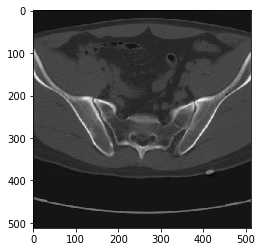

In [132]:
plt.imshow(X[10], cmap='gray')

In [134]:
# generate training input list
import pandas as pd

lst = []
for i in range(X.shape[0]):
    lst.append(i)
print(lst)
    
df = pd.DataFrame({'name': lst})
df.head(10)
df.to_csv('./data/train.csv',index=0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,